In [1]:
import pandas
import dask.array as da
import numpy as np
import struct
from haversine import haversine, Unit
from math import sqrt
from scipy.signal import medfilt
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder
import pytz

In [2]:
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline

MAX_MEMORY = '5g'
spark = SparkSession \
        .builder \
        .appName("FitRec") \
        .config("spark.executor.memory", MAX_MEMORY) \
        .config("spark.driver.memory", MAX_MEMORY) \
        .getOrCreate()

sc = spark.sparkContext

In [3]:
data = spark.read.json('endomondoHR_proper.json')
data.printSchema()

root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)



In [4]:
data.count()

167783

In [9]:
# Filter the outliner
# Take sample from male and female that have class balance


In [12]:
sample = data.rdd.takeSample(False, 100, 123)
sample = sc.parallelize(sample)
# sample = sample.filter(lambda x: all(heart_rate > 40 for heart_rate in x.heart_rate))

In [13]:
sample.count()

100

In [14]:
def get_time(timestamp, long, lat):
    utc_time = datetime.fromtimestamp(timestamp)
#     tf = TimezoneFinder()
#     timezone = tf.timezone_at(lng=long, lat=lat)
#     try:
#         offset = pytz.timezone(timezone).utcoffset(utc_time)
#     except:
#         offset = timedelta(hours=0)
    true_time = utc_time - timedelta(hours=7)
    return true_time

In [15]:
def derive_feature(row):
    """
    Calculate distance
    """
    lat = medfilt(row.latitude, 3).tolist()
    long = medfilt(row.longitude, 3).tolist()
    
    alt = [0.0001893939*i for i in row.altitude] #Convert from ft to mile
    indices = range(1,len(lat))
    
    diff_alt = [0.0]
    diff_alt += [alt[i] - alt[i-1] for i in indices] 
    
    diff_time = [0.0]
    diff_time += [row.timestamp[i] - row.timestamp[i-1] for i in indices]
    
    #Calculate different of heart rate between 2 consecutive timestamp
    diff_heart = [0.0]
    diff_heart += [row.heart_rate[i] - row.heart_rate[i-1] for i in indices]
    
    #Calculate distance derive between 2 consecutive timestamps.
    #Unit: mile
    distance = [0.0]
    distance += [haversine((lat[i-1],long[i-1]), (lat[i], long[i]), unit=Unit.MILES) for i in indices]
    d_distance = [sqrt(d**2 + a**2) for d, a in zip(distance, diff_alt)] #approximate 
    
    #Calculate average derived speed between 2 consecutive timestamps.
    #Unit: MPH
    d_speed = [0.0]
    try:
        d_speed += [dist/time*3600 for dist, time in zip(d_distance[1:], diff_time[1:])]
    except:
        d_speed = [0.0] * len(row.timestamp)
        
    #Get local hours
    hours = []
    minutes = []
    for (lg, lt, ts) in zip(row.longitude, row.latitude, row.timestamp):
        local_time = get_time(ts,lg,lt)
        hours.append(local_time.hour)
        minutes.append(local_time.minute)
    return Row(altitude = row.altitude,\
               gender = row.gender,\
               heart_rate = row.heart_rate,\
               id = row.id,\
               latitude = row.latitude,\
               longitude = row.longitude,\
               speed = row.speed,\
               sport = row.sport,\
               timestamp = row.timestamp,\
               url = row.url,\
               userId = row.userId,\
               distance = d_distance,\
               derive_speed = d_speed,\
               diff_time = diff_time,\
               diff_heart_rate = diff_heart,\
               hours = hours,\
               minutes = minutes)

In [16]:
def transform(row, lag=2):
    """
    Transform a workout session to multiples window frames.
    """
    prefix = [row.id, row.url, row.userId, row.sport, row.gender]
    flatted = []
    speed = row.speed if row.speed is not None else row.derive_speed
    a_features = [row.longitude, row.latitude, row.hours]
    b_features = [speed, row.distance, row.diff_time]
    c_features = [row.heart_rate, row.diff_heart_rate]
    for idx in range(len(row.timestamp)):
        a_row = []
        b_row = []
        c_row = []
        if idx < lag:
            mask = [0.0] * (lag-idx) #[0, 0, 1]
            for a in a_features:
                a_row += mask + a[0:idx+1]
            for b in b_features:
                roller = mask + b[0:idx+1]
                b_row += roller + [float(np.min(roller)), float(np.max(roller)), float(np.mean(roller)),\
                          float(np.std(roller))]
            for c in c_features:
                roller = mask + c[0:idx+1]
                b_row += roller + [float(np.min(roller[:-1])), float(np.max(roller[:-1])), \
                                   float(np.mean(roller[:-1])), float(np.std(roller[:-1]))]
        else:
            for a in a_features:
                a_row += a[idx-lag:idx+1]
            for b in b_features:
                roller = b[idx-lag:idx+1]
#                 print(len(roller), idx)
                b_row += roller + [float(np.min(roller)), float(np.max(roller)), float(np.mean(roller)),\
                          float(np.std(roller))]
            for c in c_features:
                roller = c[idx-lag:idx+1]
                c_row += roller + [float(np.min(roller[:-1])), float(np.max(roller[:-1])), \
                                   float(np.mean(roller[:-1])), float(np.std(roller[:-1]))]
                
        tmp = a_row + b_row + c_row
        tmp = [float(x) for x in a_row + b_row + c_row]
        flatted.append(prefix + tmp)
    return flatted

In [17]:
agg_name = ['min', 'max', 'mean', 'std']
a_name = ['longitude', 'latitude', 'hours']
b_name = ['speed', 'distance', 'diff_time', 'heart_rate', 'diff_heart_rate']
column = ['id', 'url', 'userId', 'sport', 'gender']

for name in a_name:
    column += [name + '_{}'.format(i) for i in range(2, -1, -1)]
for name in b_name:
    column += [name + '_{}'.format(i) for i in range(2, -1, -1)]
    column += [name + '_{}'.format(i) for i in agg_name]
print(column)
#export feature importances
# 2 rounds of training:
#first: basic model => feature importances
#second round: importances features => train a model => better performance

#square(heart_rate), heart_rate^3, ...

['id', 'url', 'userId', 'sport', 'gender', 'longitude_2', 'longitude_1', 'longitude_0', 'latitude_2', 'latitude_1', 'latitude_0', 'hours_2', 'hours_1', 'hours_0', 'speed_2', 'speed_1', 'speed_0', 'speed_min', 'speed_max', 'speed_mean', 'speed_std', 'distance_2', 'distance_1', 'distance_0', 'distance_min', 'distance_max', 'distance_mean', 'distance_std', 'diff_time_2', 'diff_time_1', 'diff_time_0', 'diff_time_min', 'diff_time_max', 'diff_time_mean', 'diff_time_std', 'heart_rate_2', 'heart_rate_1', 'heart_rate_0', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'heart_rate_std', 'diff_heart_rate_2', 'diff_heart_rate_1', 'diff_heart_rate_0', 'diff_heart_rate_min', 'diff_heart_rate_max', 'diff_heart_rate_mean', 'diff_heart_rate_std']


In [113]:
df = sample.map(derive_feature).flatMap(transform).toDF(column)
category_cols = ['sport', 'gender']

stages =[]
for category_col in category_cols:
    str_indexer = StringIndexer(inputCol = category_col, outputCol = category_col + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[str_indexer.getOutputCol()]\
                                     , outputCols=[category_col + "_vec"])
    stages += [str_indexer, encoder]
numeric_cols = [x for x in column[5:] if x != 'diff_heart_rate_0' and x != 'heart_rate_0']
assembler_input = [c + "_vec" for c in category_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_input, outputCol='features', handleInvalid='skip')
stages += [assembler]

partial_pipeline = Pipeline().setStages(stages)
pipeline_model = partial_pipeline.fit(df)
prepared_df = pipeline_model.transform(df)

In [134]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

parameters = {'maxDepth':[3, 5, 7], 'numTrees':[5, 10, 20, 30]}

prepared_df_cv = prepared_df.withColumnRenamed('heart_rate_0', 'label')
train, test = prepared_df_cv.randomSplit([0.8, 0.2], seed=123)
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 7]) \
    .addGrid(rf.numTrees, [5, 10, 20, 30]) \
    .build()

pipeline = Pipeline(stages=[rf])

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=5)
cvModel = crossval.fit(train)

In [135]:
cvModel.bestModel.stages[0].extractParamMap()

{Param(parent='RandomForestRegressor_ab194df99ffc', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestRegressor_ab194df99ffc', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestRegressor_ab194df99ffc', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestRegressor_ab194df99ffc', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestRegressor_ab194df99ffc', name=

In [136]:
predict = cvModel.transform(test)
value_and_pred = predict.rdd.map(lambda x: (float(x.label), float(x.prediction)))
# ((real value, preditec value)) 
metrics = RegressionMetrics(value_and_pred)
# Scale of heart rate from 60 - 200

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)


MSE = 20.60161445839722
RMSE = 4.538900137521999


In [137]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
# df.select('label').cast('str')
# df.select('prediction').cast('integer')

train, test = prepared_df.randomSplit([0.8, 0.2], seed=123)
rf = RandomForestRegressor(labelCol="diff_heart_rate_0", featuresCol="features", maxDepth=7, numTrees=100)
rf_model = rf.fit(train)

predict = rf_model.transform(test)

In [87]:
print(assembler_input)

['sport_vec', 'gender_vec', 'longitude_2', 'longitude_1', 'longitude_0', 'latitude_2', 'latitude_1', 'latitude_0', 'hours_2', 'hours_1', 'hours_0', 'speed_2', 'speed_1', 'speed_0', 'speed_min', 'speed_max', 'speed_mean', 'speed_std', 'distance_2', 'distance_1', 'distance_0', 'distance_min', 'distance_max', 'distance_mean', 'distance_std', 'diff_time_2', 'diff_time_1', 'diff_time_0', 'diff_time_min', 'diff_time_max', 'diff_time_mean', 'diff_time_std', 'heart_rate_2', 'heart_rate_1', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'heart_rate_std', 'diff_heart_rate_2', 'diff_heart_rate_1', 'diff_heart_rate_min', 'diff_heart_rate_max', 'diff_heart_rate_mean', 'diff_heart_rate_std']


In [88]:
predict.count()

10081

In [138]:
value_and_pred = predict.rdd.map(lambda x: (float(x.diff_heart_rate_0), float(x.prediction)))
# ((real value, preditec value)) 
metrics = RegressionMetrics(value_and_pred)
# Scale of heart rate from 60 - 200

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

MSE = 14.425939315648481
RMSE = 3.7981494593615563


In [139]:
value_and_pred = predict.toPandas()

In [147]:
value_and_pred['rmse'] = (value_and_pred['prediction'] - value_and_pred['diff_heart_rate_0'])**2

NameError: name 'plt' is not defined

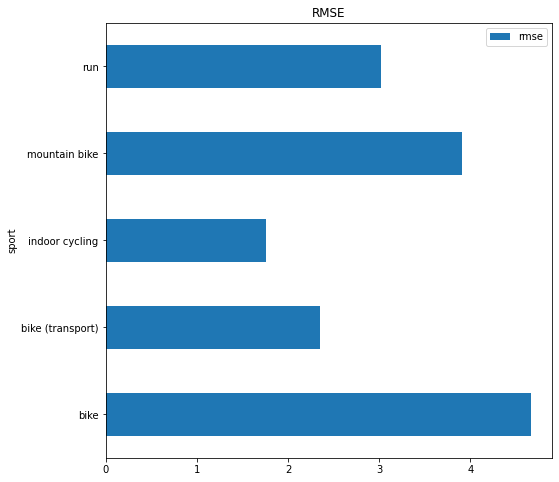

In [163]:
avg = np.sqrt(value_and_pred.groupby(['sport']).mean()[['rmse']])
avg.plot.barh(title='RMSE', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [90]:
def plot_feature_importances(importances, col_name, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt

    feat_imp = pd.DataFrame({'importance':importances})    
    feat_imp['feature'] = col_name
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

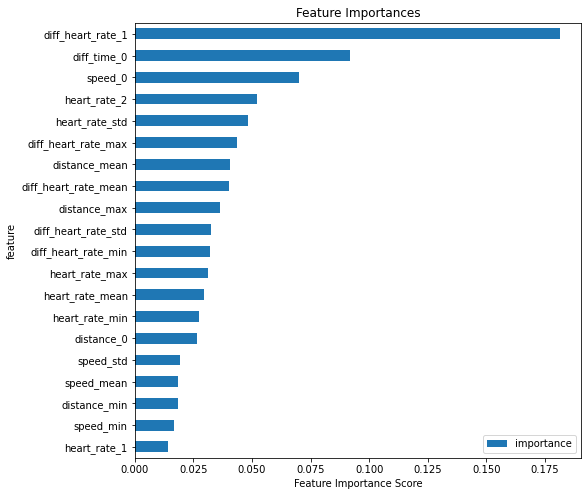

In [91]:
top_features = plot_feature_importances(rf_model.featureImportances.values, assembler_input, top_n=20)

In [92]:
top_features.index.tolist()

['heart_rate_1',
 'speed_min',
 'distance_min',
 'speed_mean',
 'speed_std',
 'distance_0',
 'heart_rate_min',
 'heart_rate_mean',
 'heart_rate_max',
 'diff_heart_rate_min',
 'diff_heart_rate_std',
 'distance_max',
 'diff_heart_rate_mean',
 'distance_mean',
 'diff_heart_rate_max',
 'heart_rate_std',
 'heart_rate_2',
 'speed_0',
 'diff_time_0',
 'diff_heart_rate_1']

In [98]:
df = sample.map(derive_feature).flatMap(transform).toDF(column)
category_cols = ['sport', 'gender']

stages =[]
for category_col in category_cols:
    str_indexer = StringIndexer(inputCol = category_col, outputCol = category_col + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[str_indexer.getOutputCol()]\
                                     , outputCols=[category_col + "_vec"])
    stages += [str_indexer, encoder]
top_ft = top_features.index.tolist()
assembler = VectorAssembler(inputCols=top_ft, outputCol='features_2', handleInvalid='skip')
stages += [assembler]

partial_pipeline = Pipeline().setStages(stages)
pipeline_model = partial_pipeline.fit(df)
prepared_df_1 = pipeline_model.transform(df)

train_1, test_1 = prepared_df_1.randomSplit([0.8, 0.2], seed=123)
rf_1 = RandomForestRegressor(labelCol="diff_heart_rate_0", featuresCol="features_2")
rf_model_1 = rf.fit(train)

predict = rf_model_1.transform(test)

value_and_pred = predict.rdd.map(lambda x: (float(x.diff_heart_rate_0), float(x.prediction)))
# ((real value, preditec value)) 
metrics = RegressionMetrics(value_and_pred)
# Scale of heart rate from 60 - 200

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

MSE = 15.196365626966822
RMSE = 3.898251611551879
